# Summary

## Training data
~ 2M executable files gathered in January 2016 with results from ReversingLabs AV experts and ThreatGrid feature evaluation

## Classification methods

1. Straightforward division of executables:
    - $k >= 10$ positive verdicts from RL: Training label is positive
    - $k < 10$ positive verdicts from RL: Training label is negative
    
   Train a logistic regression classifier on these labels and evaluate results

2. Use EM algorithm to learn labellings in unsupervised context; train a logistic regression classifier on the final output and evaluate results

3. Use fully generative classifier to learn labellings and the classifier as one

## Evaluation metrics

1. Use existing corpus of data and identify files *guaranteed* to be/not be malware

2. Use newly-gathered set of time-lapse data to evaluate  


In [1]:
import numpy as np
import pandas as pd
import os, sys
import random as r

sys.path.append(os.path.abspath("C:\\Users\\chris_000\\PycharmProjects\\cisco_project\\src"))
import loader, em, transform, eval_set

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

In [403]:
plt.rcParams['figure.figsize'] = (15, 5)

In [411]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 22

# Data Processing

## Training data
~ 2M executable files gathered in January 2016 with results from ReversingLabs AV experts and ThreatGrid feature evaluation.

In [2]:
RL_final = loader.produce_labelsarray("exec", keep='first')

Loading in RL info table (master file list)
Master file corpus size:  3829275
File corpus size fulfilling docstring exec: 2426854
Filter size:  2242949
ID Array size:  2242949
Reading in features IDs
ThreatGrid file corpus size:  3814330
Loading in AV hits data
Pivoting hits data
Merging data into ID array
Subbing in zero values for *clean* files
Complete.


Our anti-virus vendor data takes the form of a list of unique file identifiers and a binary matrix, with rows corresponding to file IDs and columns to the anti-virus vendor names. There are additionally columns containing IDs for mapping to other data sets, and a numeric field `scan_length` indicating the duration since the file was first seen by ReversingLabs. 

In [3]:
RL_final.head()

index                                             sha256  scan_length  \
0      0  c2618aed5a8e4d11e9bcc7ee8505c8e3bd2e2d0f741a60...    37.191667   
1      1  c26b9b1dfa66611a2d116900f225ee789d16c2314016fe...    38.401389   
2      2  c26318ed21f7d5fd22e48f3136f8c621bcd9fb0e66845e...     7.009028   
3      3  c261955f613c161c1dd70ef1e225f27edcf3a47ec03c0e...   292.647917   
4      5  c2699f0383452ec83ba6cde810f0e5a9e287484896bc9c...    40.070833   

   submission_id  ahnlab  antivir  avast  avg  bitdefender  ca_av  \
0              0       0        0      0    0            0      0   
1      128232933       1        1      0    1            0      0   
2              0       0        0      0    0            0      0   
3      128493663       1        1      1    1            1      0   
4      128514428       1        1      1    1            1      0   

      ...       sophos_online  sunbelt  symantec  symantec_beta  \
0     ...                   0        0         0              0   
1     ...                   1        1         0              1   
2     ...                   0        0         0              0   
3     ...                   1        1         0              1   
4     ...                   1        1         0              1   

   symantec_online  trendmicro  trendmicro_beta  trendmicro_consumer  vba32  \
0                0           0                0                    0      0   
1                0           0                0                    1      1   
2                0           0                0                    0      0   
3                0           0                0                    1      1   
4                0           0                0                    1      1   

   virusbuster  
0            0  
1            0  
2            0  
3            0  
4            1  

[5 rows x 44 columns]

Note that an initial scan by ReversingLabs does not translate to that being the first time the file was witnessed by the individual anti-virus vendors; this complicates use of the scan length to identify "new" files, although the metric is fine for identifying "old" files.

In [197]:
TG_ioc = loader.get_TGfeatures(RL_final['submission_id'].values)

Loading ThreatGrid features data file
Feature array size:  19600053
Filtering to include only files in corpus
Feature array size:  16277953
Complete.


ThreatGrid provides a list of files and the binary features that each file triggers. This data is synchronised by labels to the AV vendor data and transformed into a sparse matrix for ease of storage.

In [198]:
#RL_final, X = transform.get_datasets(RL_final, TG_ioc)
_, X = transform.get_datasets(RL_final, TG_ioc)
%reset_selective -f TG_ioc
#Y = RL_final.iloc[: ,4:].values

In [21]:
list(zip(np.arange(0,40), RL_final.columns[4:]))

[(0, 'ahnlab'),
 (1, 'antivir'),
 (2, 'avast'),
 (3, 'avg'),
 (4, 'bitdefender'),
 (5, 'ca_av'),
 (6, 'clamav'),
 (7, 'command'),
 (8, 'command_online'),
 (9, 'drweb'),
 (10, 'esetnod32'),
 (11, 'f_prot'),
 (12, 'fortinet'),
 (13, 'gdata'),
 (14, 'ikarus'),
 (15, 'k7computing'),
 (16, 'kaspersky'),
 (17, 'kaspersky_online'),
 (18, 'mcafee'),
 (19, 'mcafee_beta'),
 (20, 'mcafee_online'),
 (21, 'mcafeegwedition_online'),
 (22, 'microsoft'),
 (23, 'norman'),
 (24, 'panda'),
 (25, 'panda_online'),
 (26, 'quickheal'),
 (27, 'rising'),
 (28, 'rising_online'),
 (29, 'sophos'),
 (30, 'sophos_online'),
 (31, 'sunbelt'),
 (32, 'symantec'),
 (33, 'symantec_beta'),
 (34, 'symantec_online'),
 (35, 'trendmicro'),
 (36, 'trendmicro_beta'),
 (37, 'trendmicro_consumer'),
 (38, 'vba32'),
 (39, 'virusbuster')]

In [199]:
all_cols = np.arange(X.shape[1])
delete_cols = [413]
keep_cols = np.where(np.logical_not(np.in1d(all_cols, delete_cols)))[0]
X_new = X[:, keep_cols]
X = X_new

We now have all the data we need for training. We can split this into training and test sets and use the test set as our hold-out data. A subset of this test data (and the train data) will be viable for heuristic-based evaluation.

# Evaluation Metrics

## Metric 1: Existing Data with Restrictive Heuristics

Use existing corpus of data and identify files *guaranteed* to be/not be malware

- Any file with $k = 0$ positive verdicts and a time lapse of > 1 month since initial scan by ReversingLabs is believed to be safe. *Future enhancement: Make use of whitelisted file databases to identify non-malware files*

- Any file with $k >= 20$ positive verdicts is believed to be bad. No time lapse needed; intuition is that majority of AV vendors would not give false positives given prior information on their inherent biases.

In [285]:
X.shape

(2119682, 413)

(array([ 17.,  15.,  54.,  41.,  17.,   3.,   1.,   1.,   3.,   6.,   7.,
         36.,  15.,  10.,   3.,   3.,   2.,   8.,   6.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 <a list of 39 Patch objects>)

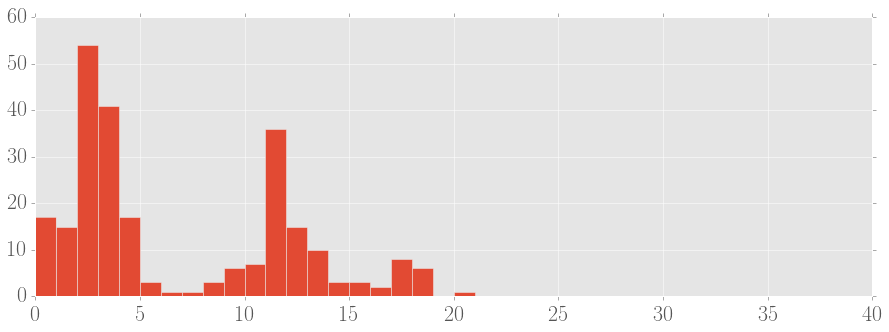

In [303]:
plt.hist(label_count[np.array(X[:, 73].toarray().flatten(), dtype=bool)], bins=np.arange(0,40))

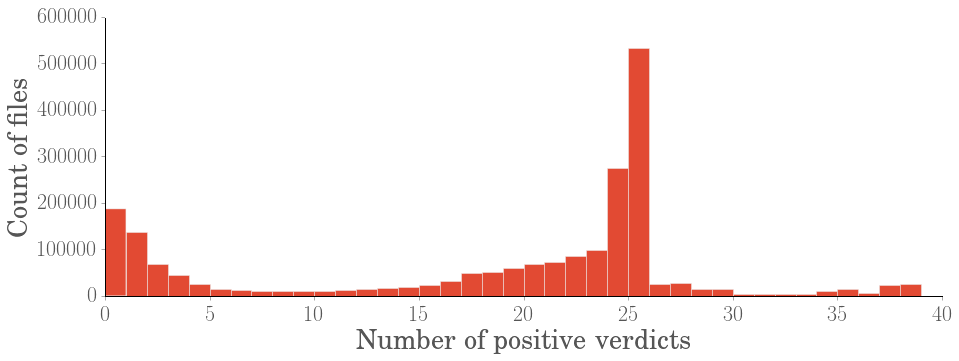

In [332]:
label_count = Y.sum(axis=1)
#inds = 
#lbl_symanteconline = label_count[np.array(Y.transpose()[21], dtype=bool)]
fig, ax = plt.subplots(1,1)
ax.set_axis_bgcolor('white')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.hist(label_count, bins=np.arange(0,40))

ax.set_xlabel('Number of positive verdicts')
ax.set_ylabel('Count of files')
#plt.hist(lbl_symanteconline, bins=np.arange(0,40))
fig.savefig('../data/report/chp2_train_counts.pdf', bbox_inches='tight')

In [32]:
true_labels = np.nan * np.ones(len(Y))
arr1 = np.array(Y.sum(axis=1) >= 15)
arr2 = np.array(Y.sum(axis=1) == 0)
arr3 = np.array(RL_final['scan_length'].values >= 30)
arr4 = np.logical_and(arr2, arr3)
true_labels[arr1] = 1
true_labels[arr4] = 0

In [200]:
X.shape

(2119682, 413)

In [202]:
X.getnnz() / (X.shape[0] * X.shape[1])

0.0184759314244343

For this analysis, a 75/25 split of training and test data is used.

In [203]:
# rng = range(len(Y))
# train_inds = np.random.choice(rng, size=int(len(Y)*0.75), replace=False)
# test_inds = list(set(rng) - set(train_inds))

X_train = X[train_inds]
X_test = X[test_inds]

# Y_train = Y[train_inds]
# Y_test = Y[test_inds]

# Z_true_train = true_labels[train_inds]
# Z_true_test = true_labels[test_inds]

# Z_train_inds = np.logical_or(Z_true_train == 1, Z_true_train == 0)
# Z_test_inds = np.logical_or(Z_true_test == 1, Z_true_test == 0)

# Z_true_train = Z_true_train[Z_train_inds]
# Z_true_test = Z_true_test[Z_test_inds]

## Metric 2: New Data with Movement Heuristics

Use newly-gathered set of time-lapse data to evaluate  

- Have at present ~1000 newly-gathered files with verdicts from VirusTotal (a separate AV aggregator engine) along with evaluation of the files using ThreatGrid to get the features. Files were chosen such that at initial scan they had only $k \in [1,4]$ positive verdicts.
    
- Can use time-lapse based heuristics to identify likely malware labelling:
    - If $k = 0$ at latest scan: Label file as non-malware
    - If $k > 4$ at latest scan: Label file as malware
        
- Current data set only has 1-2 days of time lapse between first and last scan. As such heuristic rules are stricter. A larger data set and longer lapse times will be available when data is gathered next week.
    
- Use of VirusTotal means a different set of AV engines to tackle; however 16 AV engines overlap between the different providers. As such three separate evaluations can be made for the fully generative models:    
    - Using AV vendor labels alone with learned false and true positive rates for the engines
    - Using logisitic regression classifier alone
    - Using both logistic regression and AV vendor labels in fully generative evaluation
        
- Assumption made that files are valid for evaluation with a classifier trained on executables; this is likely to be the case given that the large majority of malware-infected files are executable-style files. Future data collection will hopefully verify this.

In [57]:
eval_data = pd.read_csv('../data/ucl/ucl/verdict_ops.csv')
TG_eval = pd.read_csv('../data/ucl/ucl/TG_ops.csv')

In [356]:
before = eval_data.iloc[:,4].values
after = eval_data.iloc[:,8].values
movement = eval_data.iloc[:,11].values

In [477]:
eval_data.columns

Index(['Unnamed: 0', 'sha256', 'time_x', 'verdicts_x', 'positives_x',
       'submissions_x', 'time_y', 'verdicts_y', 'positives_y', 'submissions_y',
       'lapse', 'movement', 'drweb', 'gdata', 'symantec', 'trendmicro',
       'vba32', 'avast', 'microsoft', 'clamav', 'kaspersky', 'bitdefender',
       'mcafee', 'sophos', 'ikarus', 'fortinet', 'avg', 'panda', 'label',
       'in_TG'],
      dtype='object')

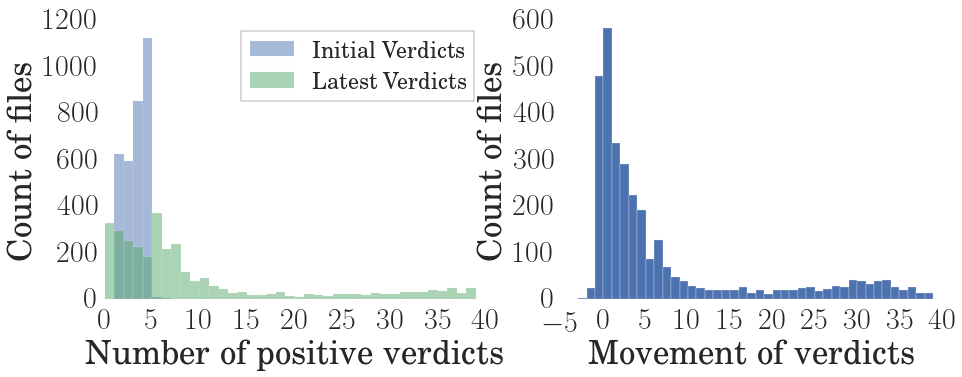

In [426]:
#3,8
#label_count = Y.sum(axis=1)
#inds = 
#lbl_symanteconline = label_count[np.array(Y.transpose()[21], dtype=bool)]
fig, ax = plt.subplots(1,2)
ax[0].set_axis_bgcolor('white')
ax[0].spines['bottom'].set_color('black')
ax[0].spines['left'].set_color('black')
ax[0].xaxis.set_ticks_position('bottom')
ax[0].yaxis.set_ticks_position('left')

ax[0].hist(before, alpha=0.5, bins=np.arange(0,40), label='Initial Verdicts')
ax[0].hist(after, alpha=0.5, bins=np.arange(0,40), label='Latest Verdicts')

ax[0].set_xlabel('Number of positive verdicts')
ax[0].set_ylabel('Count of files')

leg = ax[0].legend(loc=1, fontsize=22, frameon = 1)
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

ax[1].set_axis_bgcolor('white')
ax[1].spines['bottom'].set_color('black')
ax[1].spines['left'].set_color('black')
ax[1].xaxis.set_ticks_position('bottom')
ax[1].yaxis.set_ticks_position('left')

ax[1].hist(movement, bins=np.arange(-4,40))

ax[1].set_xlabel('Movement of verdicts')
ax[1].set_ylabel('Count of files')



#plt.hist(lbl_symanteconline, bins=np.arange(0,40))
fig.savefig('../data/report/chp2_eval_counts.pdf', bbox_inches='tight')

In [69]:
TG_eval = TG_eval.drop(3123)

In [204]:
#eval_data, TG_eval = eval_set.get_evalarrays()
#X_eval = TG_eval.iloc[:,1:].values
X_eval = TG_eval.iloc[:,1:-1].values
#Y_eval = eval_data.iloc[:,9:-1]
# Y_eval = eval_data.iloc[:,12:-2]
# Z_eval = eval_data['label'].values

# Z_eval_ind = np.array(Z_eval != -1)
# Z_eval = Z_eval[Z_eval_ind]
X_eval = X_eval[Z_eval_ind]
# Y_eval = Y_eval[Z_eval_ind]

In [205]:
X_eval= X_eval[:, keep_cols]

In [207]:
# tempval = X_eval.sum(axis=1)
# np.argmax(tempval)
# TG_eval.iloc[1128,-1]
X_eval.shape

(2267, 413)

# Classification Methods

## Approach 1: Heuristic-based Labelling

The simplest method of ground-truth labelling employed in the literature with multiple experts is to use a $k$ of $n$ approach to the anti-virus vendors:

1. Define a threshold value $k$.
2. If $k$ or more vendors label a file as malware, then the file is considered malware; else the file is considered clean.

The approach is limited by several factors:
- No weighting of individual vendor performance
- No consideration of the dependence structure of multiple vendors

A classifier can be directly trained on the features using these labels.

In [208]:
thresholds = np.arange(2,16,1)
clfs = []
labels = []

for threshold in thresholds:
    #threshold = 15
    # Get heuristic labels
    Z = np.array(Y_train.sum(axis=1) >= threshold).astype(int)

    print("Training Z = %d threshold classifier..." % threshold)
    clf = LogisticRegression(solver='sag')

    clf.fit(X_train, Z)

    clfs.append(clf)
    labels.append("Z = %d," % threshold)

Training Z = 2 threshold classifier...
Training Z = 3 threshold classifier...
Training Z = 4 threshold classifier...
Training Z = 5 threshold classifier...
Training Z = 6 threshold classifier...
Training Z = 7 threshold classifier...
Training Z = 8 threshold classifier...
Training Z = 9 threshold classifier...
Training Z = 10 threshold classifier...
Training Z = 11 threshold classifier...
Training Z = 12 threshold classifier...
Training Z = 13 threshold classifier...
Training Z = 14 threshold classifier...
Training Z = 15 threshold classifier...


In [215]:
k = 2
for c in clfs:
    err1 = misclassification_error(c, X_test[Z_test_inds], Z_true_test)
    #ce1 = #cross_entropy_error(c, X_test[Z_test_inds], Z_true_test)
    fpr, tpr, auc1 = get_roc(c, X_test[Z_test_inds], Z_true_test)
    auc1_1 = getAUC_Capped(fpr, tpr, cap=0.1)
    err2 = misclassification_error(c, X_eval, Z_eval)
    #ce2 = cross_entropy_error(c, X_eval, Z_eval)
    fpr, tpr, auc2 = get_roc(c, X_eval, Z_eval)
    auc2_1 = getAUC_Capped(fpr, tpr, cap=0.001)
    #print(str(k) + " & " + str(err1) + " & " + str(ce1) + " & " + str(auc1) + " & " + str(err2) + " & " 
    #      + str(ce2) + " & " + str(auc2) + " \\")
    print("%d & %.3f & %.4f & %.4f & %.3f & %.3f & %.3f \\\\" % (k, err1, auc1_1, auc1, err2, auc2_1, auc2))
    k += 1

2 & 0.961 & 0.9289 & 0.9835 & 0.627 & 0.119 & 0.825 \\
3 & 0.957 & 0.9280 & 0.9841 & 0.595 & 0.158 & 0.780 \\
4 & 0.950 & 0.9287 & 0.9842 & 0.506 & 0.148 & 0.757 \\
5 & 0.945 & 0.9295 & 0.9845 & 0.493 & 0.139 & 0.749 \\
6 & 0.943 & 0.9296 & 0.9842 & 0.489 & 0.135 & 0.746 \\
7 & 0.941 & 0.9299 & 0.9841 & 0.460 & 0.130 & 0.746 \\
8 & 0.940 & 0.9298 & 0.9839 & 0.459 & 0.129 & 0.739 \\
9 & 0.937 & 0.9297 & 0.9839 & 0.449 & 0.126 & 0.737 \\
10 & 0.935 & 0.9296 & 0.9837 & 0.438 & 0.125 & 0.739 \\
11 & 0.934 & 0.9297 & 0.9836 & 0.433 & 0.125 & 0.742 \\
12 & 0.932 & 0.9296 & 0.9830 & 0.411 & 0.124 & 0.743 \\
13 & 0.930 & 0.9292 & 0.9825 & 0.407 & 0.125 & 0.744 \\
14 & 0.927 & 0.9285 & 0.9811 & 0.401 & 0.124 & 0.742 \\
15 & 0.917 & 0.9270 & 0.9801 & 0.384 & 0.124 & 0.755 \\


In [191]:
fpr, tpr, auc = get_roc(clfs[0], X_test[Z_test_inds], Z_true_test)

#fpr, tpr, _ = roc_curve(np.array([0, 0, 1, 1]), np.array([0.1, 0.4, 0.35, 0.8]))
#auc = roc_auc_score(np.array([0, 0, 1, 1]), np.array([0.1, 0.4, 0.35, 0.8]))

def getAUC_Capped(fpr, tpr, cap=1.0):
    auc = 0
    for i in range(1, len(fpr)):
        width = min(fpr[i],cap) - fpr[i-1]
        height = tpr[i-1]
        auc += width*height
        if fpr[i] > cap: break
    return auc / cap

print(fpr, tpr)
auc1 = getAUC_Capped(fpr, tpr, cap=0.001)
print(auc)
print(auc1)

[ 0.          0.          0.         ...,  0.99988412  0.99988412  1.        ] [ 0.18854388  0.18914871  0.19118575 ...,  0.99999738  1.          1.        ]
0.981734319122
0.613705512606


In [115]:
# coefs = clfs[0].coef_[0]
# # print(max(coefs))
# # print(min(coefs))
# # print(np.where(coefs==max(coefs)))
# # print(np.where(coefs==min(coefs)))
# top5 = np.argpartition(coefs, -5)[-5:]
# top5 = top5[np.argsort(coefs[top5])][::-1]
# bottom5 = np.argpartition(coefs, 5)[0:5]
# bottom5 = bottom5[np.argsort(coefs[bottom5])]
# print(list(zip(bottom5, coefs[bottom5])))

def getKfeatures(clf, k, output='both'):
    coefs = clf.coef_[0]
    if output == 'both' or output == 'top':
        topK = np.argpartition(coefs, -k)[-k:]
        topK = topK[np.argsort(coefs[topK])][::-1]
        topK = list(zip(topK, coefs[topK]))
        if output == 'top': return topK
    if output == 'both' or output == 'bottom':
        bottomK = np.argpartition(coefs, k)[0:k]
        bottomK = bottomK[np.argsort(coefs[bottomK])]
        bottomK = list(zip(bottomK, coefs[bottomK]))
        if output == 'bottom': return bottomK
    return topK, bottomK

In [175]:
def misclassification_error(clf, feats, labels):
    return clf.score(feats, labels)

def cross_entropy_error(clf, feats, labels):
    res = clf.predict_log_proba(feats)
    loss = 0.0
    for ind in range(0, len(res)):
        loss += res[ind][labels[ind]]
    return loss / len(labels)

def get_roc(clf, feats, labels):
    probs = clf.predict_proba(feats)
    fpr, tpr, _ = roc_curve(labels, probs[:,1], pos_label=1)
    auc = roc_auc_score(labels, probs[:,1])
    return fpr, tpr, auc

In [300]:
getKfeatures(clfs[3], 3)

([(198, 6.981923544477568),
  (331, 5.2661077845553637),
  (332, 4.8396562829062786)],
 [(63, -4.1115815167219267),
  (233, -3.7452777769285457),
  (73, -3.2098141456193958)])

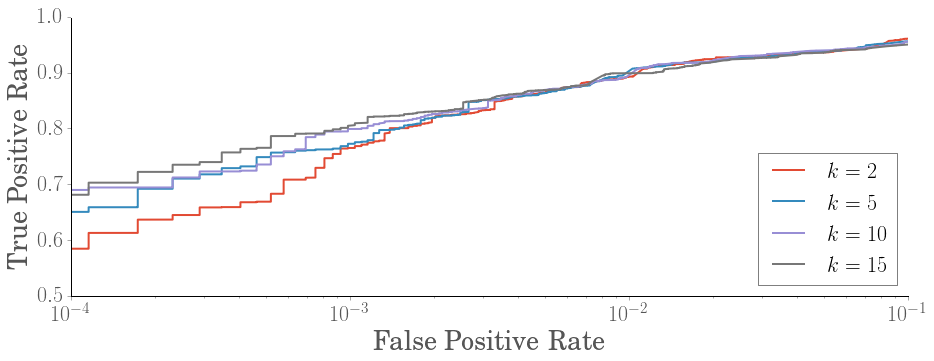

In [276]:
fig, ax = plt.subplots(1,1)
ax.set_axis_bgcolor('white')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

no_discrim = 10**(np.arange(-5,0,0.1))
for i in [0, 3, 8, 13]:
    fpr, tpr, auc = get_roc(clfs[i], X_test[Z_test_inds], Z_true_test)
    ax.semilogx(fpr, tpr,label="$k = %d$" % (i+2), linewidth=2)

ax.plot(no_discrim,no_discrim,'--',color='black',linewidth=2)

leg = ax.legend(loc=4, fontsize=22, frameon = 1)
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
ax.set_xlim([1e-4,1e-1])
ax.set_ylim([0.5,1])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

fig.savefig('../data/report/chp2_test_roc.pdf', bbox_inches='tight')

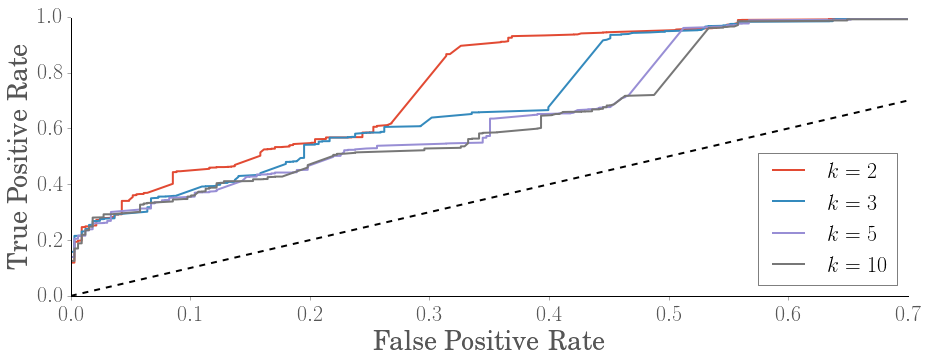

In [279]:
fig, ax = plt.subplots(1,1)
ax.set_axis_bgcolor('white')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

no_discrim = 10**(np.arange(-5,0,0.1))
for i in [0, 1, 3, 8]:
    fpr, tpr, auc = get_roc(clfs[i], X_eval, Z_eval)
    ax.plot(fpr, tpr,label="$k = %d$" % (i+2), linewidth=2)

ax.plot(no_discrim,no_discrim,'--',color='black',linewidth=2)

leg = ax.legend(loc=4, fontsize=22, frameon = 1)
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
ax.set_xlim([0,0.7])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

fig.savefig('../data/report/chp2_eval_roc.pdf', bbox_inches='tight')

In [43]:
def plot_results(clfs, labels, title):
    fig, ax = plt.subplots(1,3)
    ind = 0
    
    no_discrim = 10**(np.arange(-5,0,0.1))
    ax[0].semilogx(no_discrim,no_discrim,'b--')
    ax[1].semilogx(no_discrim,no_discrim,'b--')
    ax[2].plot([0,1],[0,1],'b--')
    
    for clf in clfs:
        prob_out_train = clf.predict_proba(X_train[Z_train_inds])
        prob_out_test = clf.predict_proba(X_test[Z_test_inds])
        prob_out_eval = clf.predict_proba(X_eval)
        
        fpr_train, tpr_train, _ = roc_curve(Z_true_train, prob_out_train[:,1], pos_label=1)
        fpr_test, tpr_test, _ = roc_curve(Z_true_test, prob_out_test[:,1], pos_label=1)
        fpr_eval, tpr_eval, _ = roc_curve(Z_eval, prob_out_eval[:,1], pos_label=1)
        
        auc_train = roc_auc_score(Z_true_train, prob_out_train[:,1])
        auc_test = roc_auc_score(Z_true_test, prob_out_test[:,1])
        auc_eval = roc_auc_score(Z_eval, prob_out_eval[:,1])
        
        ax[0].semilogx(fpr_train,tpr_train,label=str(labels[ind] + " AUC: %f" % auc_train))
        ax[1].semilogx(fpr_test,tpr_test,label=str(labels[ind] + " AUC: %f" % auc_test))
        ax[2].plot(fpr_eval,tpr_eval,label=str(labels[ind] + " AUC: %f" % auc_eval))
        
        ind += 1
    
    fig.suptitle(title,fontsize=16)
    
    ax[0].set_title("Train data")
    ax[1].set_title("Test data")
    ax[2].set_title("Eval data")
    
    for i in range(0, 3):
        ax[i].legend(loc=4)
        ax[i].set_xlabel("FP rate")
        ax[i].set_ylabel("TP rate")

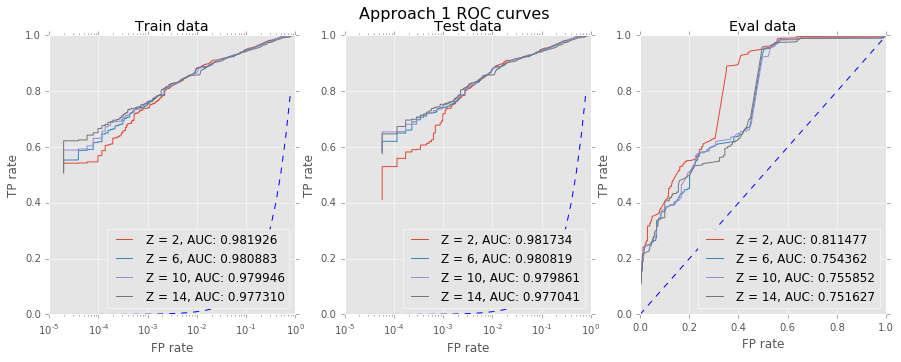

In [72]:
plot_results(clfs, labels, "Approach 1 ROC curves")

The results show that the train and test data sets are strongly robust to different threshold settings of the classification boundary. This follows from the nature of the data, as our "true" labels are defined at the extremes of the AV vendor count range and so the uncertainty introduced by the threshold setting should have minimal effect on label assignment.

The evaluation data shows significantly worse performance, although the data set is very small. Interestingly the classifier prefers a much lower threshold on Z for classification; this perhaps corresponds to the nature of the data, which for evaluation purposes has yet to mature fully and still features on average very low vendor counts.

## Approach 2: Unsupervised Label Learning

This method takes a fully unsupervised approach to learning the ground-truth labels for the training data. An Expectation Maximisation algorithm iterates between learning the ground-truth labels given the veracity of vendors and vice-versa until convergence is achieved. The final ground-truth labels can then be used to directly train a classifier (in this case, a logistic regression classifier) on the ThreatGrid features for use in evaluation.

The EM Algorithm approach follows that used in Kantchelian et al. on a similar corpus of data.

### Data

The following notation is used for the data:

 - $X_{ik}$: The ThreatGrid feature values; not used in the generative model. $i = 1...N$ indexes over files; $k = 1...K$ indexes over features.
 - $Y_{ij}$: The Anti-Virus vendor reports used in the generative model. $j = 1...M$ indexes over vendors.
 
For files we aim to learn $Z_i$, corresponding to the probabilistic ground-truth labelling for the file.

For vendors we aim to learn $\alpha_j$, $\beta_j$, corresponding to the sensitivity (true positive) and 1 - specificity (false positive) rates. We also learn the underlying probability of a file being malware, denoted by $\pi$ and constant across all files and vendors.

### EM Algorithm: Initialisations

There are three key variables to set:

1. $\phi$: Controls the bias away from true positive values (TP) for the vendor modelled by $\mathbf{\alpha}$. Set to favour false negatives over true positives to simulate anticipated biases of AV engine design.
\begin{equation}
\alpha_j \sim Beta(1,1+\phi) \; \forall j
\end{equation}

2. $\psi$: Controls the bias towards false positive values (FP) for the vendor modelled by $\mathbf{\beta}$. Set to favour true negatives over false positives to simulate anticipated biases of AV engine design.
\begin{equation}
\beta_j \sim Beta(1,1+\psi) \; \forall j
\end{equation}

3. $\theta$: Controls the underlying distribution of true labels $\pi$. Low values of $\mathbf{\theta}$ correspond to less informative prior of $\pi$; larger values concentrate the prior mass around 0.5. $\pi$ determines the parameter in a Bernouilli distribution for the latent true labels $\mathbf{Z}$. For this investigation, $\theta = 0$.
\begin{align}
\pi & \sim Beta(1+\theta,1+\theta) \\
Z_i & \sim Bernouilli(\pi) \; \forall i
\end{align}

We must also initialise the $Z_i$ values for all files. Common approaches are to retain the $k$ of $n$ threshold heuristics for initialisation.

### M-Step

The M-Step applies maximum likelihood to learn the distributions for the latent variables $\alpha$, $\beta$, $\pi$.

\begin{align}
\pi & = \frac{\theta + \sum_i z_i}{2 \theta + N} \\
\\
\alpha_j & = \frac{\sum_i z_i Y_{ij}}{\phi + \sum_i z_i} \\
\\
\beta_j & = \frac{\sum_i (1-z_i)Y_{ij}}{\psi + N - \sum_i z_i} \\
\end{align}

### E-Step

The E-Step applies inference to update the ground-truth labels $z$.

\begin{equation}
z_j = \left[ 1 + \frac{1-\pi}{\pi} \prod_{j=1}^{M}  \left( \frac{\beta_j}{\alpha_j}  \right)^{Y_{ij}} \left( \frac{1 - \beta_j}{1 - \alpha_j}  \right)^{1 - Y_{ij}} \right]^{-1}
\end{equation}

### Convergence and Stability

The learned parameters $\alpha$, $\beta$ and $\pi$ are constrained within the range $[\epsilon, 1-\epsilon]$ to cap extreme values for stability purposes. $\epsilon$ is chosen to be $10^{-3}$.

Convergence is obtained when the sum of the absolute parameter values for all $\alpha$, $\beta$ and $\pi$ values relative to their previous update do not exceed some value $\delta$. $\delta$ is selected to be $10^{-12}$.

The algorithm is capped at 500 iterations in the event convergence is not achieved.

The algorithm on completion will return the learned values for latent variables: 

- $Z_i$ (ground truth labels for each file) 
- $\alpha_j$ (TP rates for each vendor)
- $\beta_j$ (FP rates for each vendor)
- $\pi$ (Underlying probability of malware in dataset)

### Classifier

In the absence of a true probabilistic classifier for now (a simple planned extension), a threshold value $\gamma$ must be set on the learned probabilistic labels $Z_i$:

- $Z_i >= \gamma$: The file is considered malware for training purposes.
- $Z_i < \gamma$: The file is considered "clean" for training purposes.

An L2-regularised logistic regression classifier is used on the subsequent labels.

In [476]:
#thresholds = [2,6,10]
N = len(Y_train)

phi_vals = [2.2*N]#np.arange(0,2.2*N,0.2*N)
psi_vals = np.arange(0,0.6*N,0.1*N)

Z_arr = []
alpha_arr = []
beta_arr = []
pi_arr = []
params_arr = []

t = 5

for phi in phi_vals:
    for psi in psi_vals:
        #for t in thresholds:
        print([phi,psi])
        params_arr.append(np.array([phi,psi]))
        Z = np.array(Y_train.sum(axis=1) >= t).astype(int)
        Z, alpha, beta, pi = em.EMAlgorithm(Y_train, Z, phi, psi)
        Z_arr.append(Z)
        alpha_arr.append(alpha)
        beta_arr.append(beta)
        pi_arr.append(pi)

[3497474.2, 0.0]
Beginning EM algorithm...
Iteration 0 of 500
    Log-likelihood:  -72858351.1051
    Movement in ground truth probability:  0.781420603474
    Movement in ground truth labels:  30683
Iteration 1 of 500
    Log-likelihood:  -72832140.479
    Movement in ground truth probability:  0.0175210590521
    Movement in ground truth labels:  5201
Iteration 2 of 500
    Log-likelihood:  -72830414.4219
    Movement in ground truth probability:  0.00415109237605
    Movement in ground truth labels:  2224
Iteration 3 of 500
    Log-likelihood:  -72830136.4431
    Movement in ground truth probability:  0.0013442893241
    Movement in ground truth labels:  307
Iteration 4 of 500
    Log-likelihood:  -72830067.5519
    Movement in ground truth probability:  0.000542280294795
    Movement in ground truth labels:  129
Iteration 5 of 500
    Log-likelihood:  -72830042.5582
    Movement in ground truth probability:  0.00025390260635
    Movement in ground truth labels:  197
Iteration 6 of 

In [458]:
joblib.dump([Z_arr,alpha_arr,beta_arr,pi_arr],'../data/output/unsup/res.pkl')

['../data/output/unsup/res.pkl',
 '../data/output/unsup/res.pkl_01.npy',
 '../data/output/unsup/res.pkl_02.npy',
 '../data/output/unsup/res.pkl_03.npy',
 '../data/output/unsup/res.pkl_04.npy',
 '../data/output/unsup/res.pkl_05.npy',
 '../data/output/unsup/res.pkl_06.npy',
 '../data/output/unsup/res.pkl_07.npy',
 '../data/output/unsup/res.pkl_08.npy',
 '../data/output/unsup/res.pkl_09.npy',
 '../data/output/unsup/res.pkl_10.npy',
 '../data/output/unsup/res.pkl_11.npy',
 '../data/output/unsup/res.pkl_12.npy',
 '../data/output/unsup/res.pkl_13.npy',
 '../data/output/unsup/res.pkl_14.npy',
 '../data/output/unsup/res.pkl_15.npy',
 '../data/output/unsup/res.pkl_16.npy',
 '../data/output/unsup/res.pkl_17.npy',
 '../data/output/unsup/res.pkl_18.npy',
 '../data/output/unsup/res.pkl_19.npy',
 '../data/output/unsup/res.pkl_20.npy',
 '../data/output/unsup/res.pkl_21.npy',
 '../data/output/unsup/res.pkl_22.npy',
 '../data/output/unsup/res.pkl_23.npy',
 '../data/output/unsup/res.pkl_24.npy',
 '../da

In [149]:
import imp
imp.reload(em)

<module 'em' from 'C:\\Users\\chris_000\\PycharmProjects\\cisco_project\\src\\em.py'>

In [465]:
Z = np.array(Y_train.sum(axis=1) >= 2).astype(int)
N = len(Y_train)
Z, alpha, beta, pi = em.EMAlgorithm(Y_train, Z, 3*N, N)

Beginning EM algorithm...
Iteration 0 of 500
    Log-likelihood:  -80669953.4094
    Movement in ground truth probability:  0.846524729189
    Movement in ground truth labels:  35181
Iteration 1 of 500
    Log-likelihood:  -80664773.389
    Movement in ground truth probability:  0.00537665144316
    Movement in ground truth labels:  0
Iteration 2 of 500
    Log-likelihood:  -80664392.9379
    Movement in ground truth probability:  -0.00227226535676
    Movement in ground truth labels:  0
Iteration 3 of 500
    Log-likelihood:  -80664327.3159
    Movement in ground truth probability:  -0.000992095414933
    Movement in ground truth labels:  0
Iteration 4 of 500
    Log-likelihood:  -80664314.0081
    Movement in ground truth probability:  -0.000382964746551
    Movement in ground truth labels:  0
Iteration 5 of 500
    Log-likelihood:  -80664311.2435
    Movement in ground truth probability:  -0.000154684044991
    Movement in ground truth labels:  0
Iteration 6 of 500
    Log-likelihoo

An analysis of the learned ground truth labels shows the majority of training candidates have been strongly classified, with:

- ~16% having $<0.1$ chance of being malware
- ~82% having $>0.9$ chance of being malware
- ~1.8% lying between these regions

In [469]:
z_vals = np.array(Z >= gamma).astype(int)
clf_emnew = LogisticRegression(solver='sag')

clf_emnew.fit(X_train, z_vals)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [496]:
joblib.dump([Z_arr1[0],Z_arr1[4],Z_arr1[8]],'../data/report/data/sup_zvals.pkl')

['../data/report/data/sup_zvals.pkl',
 '../data/report/data/sup_zvals.pkl_01.npy',
 '../data/report/data/sup_zvals.pkl_02.npy',
 '../data/report/data/sup_zvals.pkl_03.npy']

In [494]:
fpr1, tpr1, auc1 = get_roc(clf_arr1[0], X_test[Z_test_inds], Z_true_test)
fpr2, tpr2, auc2 = get_roc(clf_arr1[4], X_test[Z_test_inds], Z_true_test)
fpr3, tpr3, auc3 = get_roc(clf_arr1[8], X_test[Z_test_inds], Z_true_test)


print(auc1, auc2, auc3, auc4, auc5)

joblib.dump([[fpr1, tpr1],[fpr2, tpr2],[fpr3, tpr3]],'../data/report/data/tpfp_test_sup.pkl')

0.982147724625 0.984117511425 0.984262451452 0.759247757833 0.80433165826


['../data/report/data/tpfp_test_sup.pkl',
 '../data/report/data/tpfp_test_sup.pkl_01.npy',
 '../data/report/data/tpfp_test_sup.pkl_02.npy',
 '../data/report/data/tpfp_test_sup.pkl_03.npy',
 '../data/report/data/tpfp_test_sup.pkl_04.npy',
 '../data/report/data/tpfp_test_sup.pkl_05.npy',
 '../data/report/data/tpfp_test_sup.pkl_06.npy']

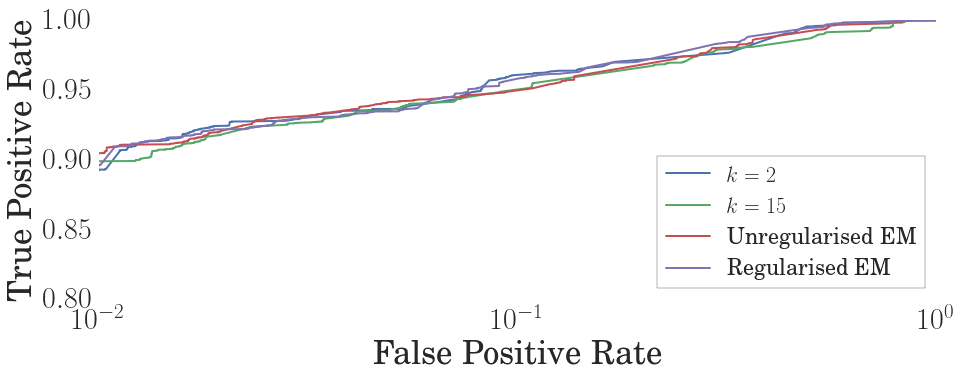

In [474]:
fig, ax = plt.subplots(1,1)
ax.set_axis_bgcolor('white')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.semilogx(fpr1, tpr1,label="$k = %d$" % 2, linewidth=2)
ax.semilogx(fpr2, tpr2,label="$k = %d$" % 15, linewidth=2)
ax.semilogx(fpr3, tpr3,label="Unregularised EM", linewidth=2)
ax.semilogx(fpr4, tpr4,label="Regularised EM", linewidth=2)

leg = ax.legend(loc=4, fontsize=22, frameon = 1)
frame = leg.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
ax.set_xlim([1e-2,1])
ax.set_ylim([0.8,1])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")


In [479]:
clfs_emnew2 = []
gamma = 0.5

for i in range(0, len(Z_arr)):
    z_vals = np.array(Z_arr[i] >= gamma).astype(int)
    print("Training phi = %d, psi = %d EM classifier..." % (params_arr[i][0], params_arr[i][1]))
    clf = LogisticRegression(solver='sag')

    clf.fit(X_train, z_vals)

    clfs_emnew2.append(clf)
    #labels.append("phi = %d, psi = %d" % (params_arr[i][0], params_arr[i][1]))

Training phi = 3497474, psi = 0 EM classifier...
Training phi = 3497474, psi = 158976 EM classifier...
Training phi = 3497474, psi = 317952 EM classifier...
Training phi = 3497474, psi = 476928 EM classifier...
Training phi = 3497474, psi = 635904 EM classifier...
Training phi = 3497474, psi = 794880 EM classifier...


In [480]:
for c in clfs_emnew2:
    err1 = misclassification_error(c, X_test[Z_test_inds], Z_true_test)
    #ce1 = cross_entropy_error(c, X_test[Z_test_inds], Z_true_test)
    ce1 = 0
    fpr, tpr, auc1 = get_roc(c, X_test[Z_test_inds], Z_true_test)
    auc1_1 = getAUC_Capped(fpr, tpr, cap=0.1)
    auc1_2 = getAUC_Capped(fpr, tpr, cap=0.01)
    err2 = misclassification_error(c, X_eval, Z_eval)
    #ce2 = cross_entropy_error(c, X_eval, Z_eval)
    ce2 = 0
    _, _, auc2 = get_roc(c, X_eval, Z_eval)
    #print(str(k) + " & " + str(err1) + " & " + str(ce1) + " & " + str(auc1) + " & " + str(err2) + " & " 
    #      + str(ce2) + " & " + str(auc2) + " \\")
    print("%.1fN & %.1fN & %.3f & %.5f & %.5f & %.5f & %.3f & %.3f \\\\" % 
          (math.floor(ind / 6) * 0.2, (ind % 6) * 0.1, err1, auc1, auc1_1, auc1_2, err2, auc2))
    ind += 1


2.2N & 0.0N & 0.951 & 0.98410 & 0.92794 & 0.84150 & 0.515 & 0.758 \\
2.2N & 0.0N & 0.956 & 0.98422 & 0.92797 & 0.84117 & 0.554 & 0.764 \\
2.2N & 0.0N & 0.957 & 0.98403 & 0.92763 & 0.84172 & 0.597 & 0.769 \\
2.2N & 0.0N & 0.959 & 0.98339 & 0.92694 & 0.84044 & 0.607 & 0.803 \\
2.2N & 0.0N & 0.959 & 0.98350 & 0.92680 & 0.83966 & 0.608 & 0.797 \\
2.2N & 0.0N & 0.959 & 0.98343 & 0.92661 & 0.83834 & 0.610 & 0.797 \\


In [485]:
#import math
ind = 0
a1, a2, a3 = [0,-1], [0,-1], [0,-1]
for c in clfs_em:
    err1 = misclassification_error(c, X_test[Z_test_inds], Z_true_test)
    ce1 = cross_entropy_error(c, X_test[Z_test_inds], Z_true_test)
    #ce1 = 0
    _, _, auc1 = get_roc(c, X_test[Z_test_inds], Z_true_test)
    #auc1_1 = getAUC_Capped(fpr, tpr, cap=0.1)
    #auc1_2 = getAUC_Capped(fpr, tpr, cap=0.01)
    err2 = misclassification_error(c, X_eval, Z_eval)
    ce2 = cross_entropy_error(c, X_eval, Z_eval)
    #ce2 = 0
    _, _, auc2 = get_roc(c, X_eval, Z_eval)
    #print(str(k) + " & " + str(err1) + " & " + str(ce1) + " & " + str(auc1) + " & " + str(err2) + " & " 
    #      + str(ce2) + " & " + str(auc2) + " \\")
    print("%.1fN & %.1fN & %.3f & %.5f & %.5f & %.5f & %.3f & %.3f \\\\" % 
          (math.floor(ind / 6) * 0.2, (ind % 6) * 0.1, err1, ce1, auc1, err2, ce2, auc2))
    #     if auc1 > a1[0]: 
    #         a1[0] = auc1
    #         a1[1] = ind
    #     if auc1_1 > a2[0]: 
    #         a2[0] = auc1_1
    #         a2[1] = ind
    #     if auc1_2 > a3[0]: 
    #         a3[0] = auc1_2
    #         a3[1] = ind
    ind += 1
#print(a1, a2, a3)

0.0N & 0.0N & 0.931 & -0.14046 & 0.98261 & 0.40891 & -0.976 & 0.739 \\
0.0N & 0.1N & 0.932 & -0.13370 & 0.98306 & 0.41332 & -0.952 & 0.741 \\
0.0N & 0.2N & 0.934 & -0.13002 & 0.98338 & 0.43449 & -0.937 & 0.742 \\
0.0N & 0.3N & 0.935 & -0.12785 & 0.98355 & 0.43582 & -0.927 & 0.742 \\
0.0N & 0.4N & 0.935 & -0.12621 & 0.98385 & 0.43626 & -0.919 & 0.743 \\
0.0N & 0.5N & 0.935 & -0.12481 & 0.98382 & 0.43979 & -0.911 & 0.739 \\
0.2N & 0.0N & 0.941 & -0.11700 & 0.98407 & 0.45876 & -0.879 & 0.732 \\
0.2N & 0.1N & 0.941 & -0.11502 & 0.98405 & 0.46008 & -0.871 & 0.731 \\
0.2N & 0.2N & 0.941 & -0.11378 & 0.98407 & 0.45964 & -0.864 & 0.731 \\
0.2N & 0.3N & 0.942 & -0.11252 & 0.98401 & 0.46184 & -0.851 & 0.731 \\
0.2N & 0.4N & 0.942 & -0.11139 & 0.98397 & 0.46184 & -0.845 & 0.730 \\
0.2N & 0.5N & 0.942 & -0.11069 & 0.98399 & 0.46493 & -0.839 & 0.731 \\
0.4N & 0.0N & 0.942 & -0.11108 & 0.98400 & 0.46449 & -0.849 & 0.730 \\
0.4N & 0.1N & 0.943 & -0.10899 & 0.98403 & 0.49007 & -0.829 & 0.731 \\
0.4N &

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [481]:
joblib.dump(clfs_em, '../data/report/data/clfs_em.pkl')

['../data/report/data/clfs_em.pkl',
 '../data/report/data/clfs_em.pkl_01.npy',
 '../data/report/data/clfs_em.pkl_02.npy',
 '../data/report/data/clfs_em.pkl_03.npy',
 '../data/report/data/clfs_em.pkl_04.npy',
 '../data/report/data/clfs_em.pkl_05.npy',
 '../data/report/data/clfs_em.pkl_06.npy',
 '../data/report/data/clfs_em.pkl_07.npy',
 '../data/report/data/clfs_em.pkl_08.npy',
 '../data/report/data/clfs_em.pkl_09.npy',
 '../data/report/data/clfs_em.pkl_10.npy',
 '../data/report/data/clfs_em.pkl_11.npy',
 '../data/report/data/clfs_em.pkl_12.npy',
 '../data/report/data/clfs_em.pkl_13.npy',
 '../data/report/data/clfs_em.pkl_14.npy',
 '../data/report/data/clfs_em.pkl_15.npy',
 '../data/report/data/clfs_em.pkl_16.npy',
 '../data/report/data/clfs_em.pkl_17.npy',
 '../data/report/data/clfs_em.pkl_18.npy',
 '../data/report/data/clfs_em.pkl_19.npy',
 '../data/report/data/clfs_em.pkl_20.npy',
 '../data/report/data/clfs_em.pkl_21.npy',
 '../data/report/data/clfs_em.pkl_22.npy',
 '../data/report/d

(array([  4.11803000e+05,   1.47200000e+03,   1.06500000e+03,
          7.80000000e+02,   6.76000000e+02,   5.85000000e+02,
          7.67000000e+02,   1.13600000e+03,   1.19500000e+03,
          1.17028200e+06]),
 array([  1.40563860e-28,   1.00000000e-01,   2.00000000e-01,
          3.00000000e-01,   4.00000000e-01,   5.00000000e-01,
          6.00000000e-01,   7.00000000e-01,   8.00000000e-01,
          9.00000000e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

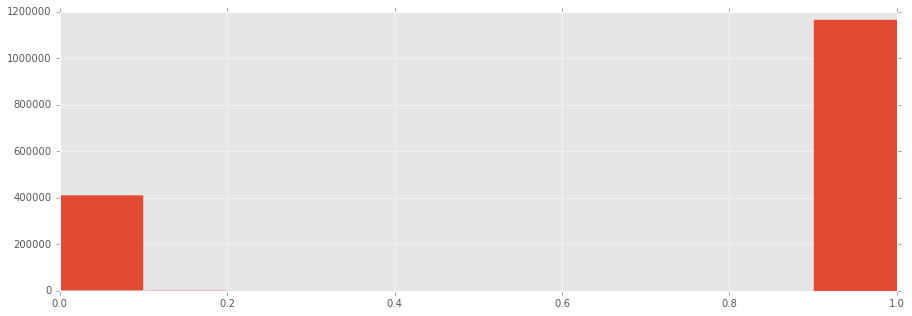

In [160]:
plt.hist(Z_arr[0],bins=10)

The proportion of malware candidates as a function of positive AV verdicts shows that the probability of being malware shoots up to nearly 1 when 5 or more AV verdicts identify the file as malware.

[ 0.          0.11945616  0.55109885]


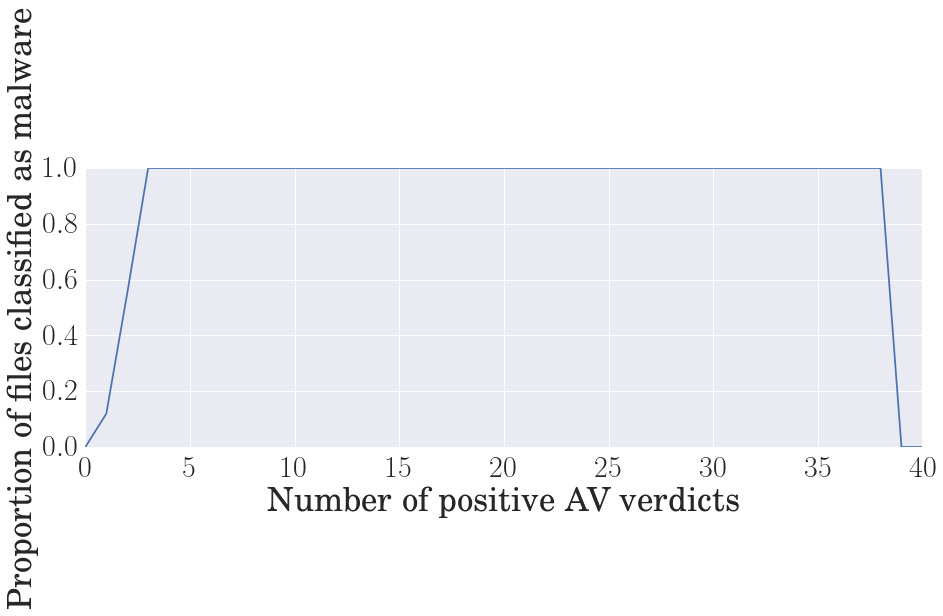

In [467]:
verdicts = Y_train.sum(axis=1)
propn = np.zeros(41)
for i in range(0, 41):
    amt = Z[verdicts==i]
    if len(amt) > 0:
        propn[i] = sum(amt>0.5) / len(amt)
    else: propn[i] = 0

print(propn[0:3])
        
fig, ax = plt.subplots(1,1)
ax.plot(propn)
ax.set_xlabel("Number of positive AV verdicts")
ax.set_ylabel("Proportion of files classified as malware")

The vendor's learned true and false positive rates are plotted below. For the most part, the true positive rates all hover round the 1/3 mark, reflecting the corresponding prevalence of false negatives in the data. The false positive rates are very low for all but a few apparently adversarial vendors; it is likely that regularisation is having a strong effect here. More work needs to be done to investigate the robustness of parameter intialisation for the algorithm.

In [475]:
cross_entropy_error(clfs_em[56], X_test[Z_test_inds], Z_true_test)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


-0.088709971163914672

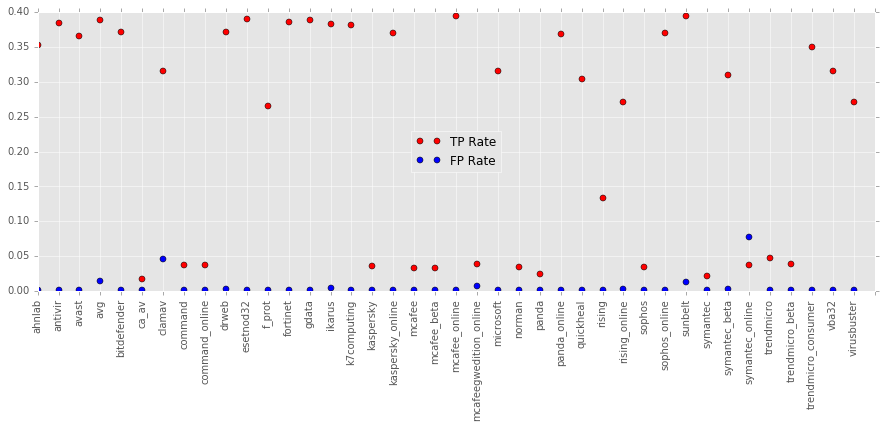

In [96]:
fig, ax = plt.subplots(1,1)
ax.plot(alpha,'ro',label='TP Rate')
ax.plot(beta,'bo',label='FP Rate')
ax.set_xticks(np.arange(41))
ax.set_xticklabels(RL_final.columns[4:], rotation='vertical')
ax.legend(loc=10)

For the classifier, we must set in advance a threshold probability to consider a file as malware or not. Given the highly clustered output, a value of $\gamma = 0.5$ as a threshold does not seem unreasonable.

In [102]:
gamma = 0.5

clf = LogisticRegression(solver='sag')
clf.fit(X_train, np.array(Z >= gamma).astype(int))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

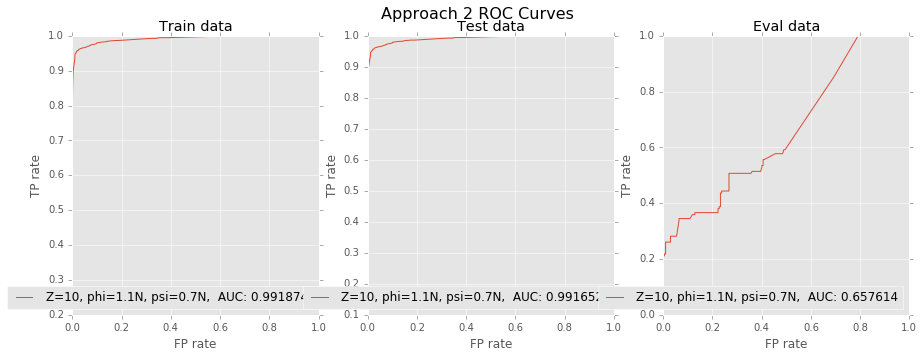

In [108]:
plot_results([clf], ["Z=10, phi=1.1N, psi=0.7N, "], "Approach 2 ROC Curves")

The learned classifier outperforms the heuristic measure settings explored for both training and test sets by AUC measures, although the margins are very minimal.

The evaluation data performance is less successful. This is again likely due in part to a lack of maturity of the data, and also the setup of the EM algorithm to have less regularisation to favour false negative rates. Exploration of more hyperparameter settings merits exploration.

## Approach 3: Fully Generative Classifier

This method expands on Approach 2 following a modified version of the recipe outlined in Raykar et al. The key change is to the probability distribution from which the ground truth labels are drawn. In Approach 2, a variable $\pi$ was learned corresponding to the data-dependent incidence proportions of malware. In place of this, we can directly incorporate the features $X_{ik}$ to learn a predicted probability based on the classifier results for a candidate to be positive or not.

### EM Algorithm: Initialisations

The initialisations remain the same for all variables except $\pi$, which is no longer drawn from a probability distribution in this model, and instead is personalised to each file:

\begin{equation}
\pi \rightarrow \pi_i
\end{equation}

### M-Step

The steps for $\alpha_j$ and $\beta_j$ are unchanged. To learn $\pi_i$, we train a classifier (in this case, an L2-regularised logistic regression classifier) on the current probabilistic labels $Z_i$ to learn the feature values $\omega_k$. We can then evaluate $\pi_i = \sigma(\omega^\top X_i)$.

### E-Step

This remains the same, except $\pi \rightarrow \pi_i$.

### Classifier

The final classifier is given by the values $\omega_k$ learned for the features in the training set. Hence the model has (in ideal conditions) learned:

- The ground-truth labels for the training set
- The sensitivity and specificity for each anti-virus vendor
- A classifier for malware detection using the ThreatGrid features

The power of this method is in utilising the feature information to inform the antivirus vendor parameters and ground-truth labelling for the dataset. In theory, this should aid in classifying borderline cases where either the AV vendor or ThreatGrid feature data is inconclusive in isolation.

In [319]:
imp.reload(em)

<module 'em' from 'C:\\Users\\chris_000\\PycharmProjects\\cisco_project\\src\\em.py'>

In [486]:
#thresholds = [2,6,10]
N = len(Y_train)

phipsi = [[0,0],[1.8*N,0.2*N],[2*N,0.5*N]]

Z_arr1 = []
alpha_arr1 = []
beta_arr1 = []
clf_arr1 = []
params_arr1 = []

thresholds = [2,3,4,5]

for p in phipsi:
    phi = p[0]
    psi = p[1]
    for t in thresholds:
        print(phi, psi, t)
        params_arr1.append(np.array([phi,psi,t]))
        Z = np.array(Y_train.sum(axis=1) >= 2).astype(int)
        Z, alpha, beta, clf_full = em.EMAlgorithm_LogisticRegression(Y_train, Z, X_train, phi, psi)
        Z_arr1.append(Z)
        alpha_arr1.append(alpha)
        beta_arr1.append(beta)
        clf_arr1.append(clf_full)
    
        
# for phi in phi_vals:
#     for psi in psi_vals:
#         #for t in thresholds:
#         print([phi,psi])
#         params_arr.append(np.array([phi,psi]))
#         Z = np.array(Y_train.sum(axis=1) >= t).astype(int)
#         Z, alpha, beta, pi = em.EMAlgorithm(Y_train, Z, phi, psi)
#         Z_arr.append(Z)
#         alpha_arr.append(alpha)
#         beta_arr.append(beta)
#         pi_arr.append(pi)

# Z_arr1 = []
# Z_arr


# Z = np.array(Y_train.sum(axis=1) >= 2).astype(int)
# Z, alpha, beta, clf_full = em.EMAlgorithm_LogisticRegression(Y_train, Z, X_train, 0, 0)

0 0 2
Beginning EM algorithm with logistic regression...
Iteration 1 of 50
    Performing logistic regression on probabilistic labels...
    Total movement in alpha + beta:  21.6593242448
    Movement in logistic regression parameters:  6.14691252784
    Movement in ground truth probabilities:  1345059.64044
    Movement in ground truth labels:  122013
    Log-likelihood:  -32698330.7792
Iteration 2 of 50
    Performing logistic regression on probabilistic labels...
    Total movement in alpha + beta:  2.78814392226
    Movement in logistic regression parameters:  5.4518239119
    Movement in ground truth probabilities:  122956.993084
    Movement in ground truth labels:  28730
    Log-likelihood:  -37598479.4841
Iteration 3 of 50
    Performing logistic regression on probabilistic labels...
    Total movement in alpha + beta:  0.881106112442
    Movement in logistic regression parameters:  1.93487867303
    Movement in ground truth probabilities:  29294.8207175
    Movement in ground 

In [492]:
#import math
ind = 0
a1, a2, a3 = [0,-1], [0,-1], [0,-1]
for c in clf_arr1:
    err1 = misclassification_error(c, X_test[Z_test_inds], Z_true_test)
    ce1 = cross_entropy_error(c, X_test[Z_test_inds], Z_true_test)
    #ce1 = 0
    _, _, auc1 = get_roc(c, X_test[Z_test_inds], Z_true_test)
    #auc1_1 = getAUC_Capped(fpr, tpr, cap=0.1)
    #auc1_2 = getAUC_Capped(fpr, tpr, cap=0.01)
    err2 = misclassification_error(c, X_eval, Z_eval)
    ce2 = cross_entropy_error(c, X_eval, Z_eval)
    #ce2 = 0
    _, _, auc2 = get_roc(c, X_eval, Z_eval)
    #print(str(k) + " & " + str(err1) + " & " + str(ce1) + " & " + str(auc1) + " & " + str(err2) + " & " 
    #      + str(ce2) + " & " + str(auc2) + " \\")
    print("%dN & %.1fN & %.3f & %.5f & %.5f & %.5f & %.3f & %.3f \\\\" % 
          (ind % 4 + 2, math.floor(ind / 4), err1, ce1, auc1, err2, ce2, auc2))
    #     if auc1 > a1[0]: 
    #         a1[0] = auc1
    #         a1[1] = ind
    #     if auc1_1 > a2[0]: 
    #         a2[0] = auc1_1
    #         a2[1] = ind
    #     if auc1_2 > a3[0]: 
    #         a3[0] = auc1_2
    #         a3[1] = ind
    ind += 1
#print(a1, a2, a3)

2N & 0.0N & 0.930 & -0.14157 & 0.98215 & 0.40803 & -0.998 & 0.741 \\
3N & 0.0N & 0.930 & -0.14157 & 0.98215 & 0.40803 & -0.998 & 0.741 \\
4N & 0.0N & 0.930 & -0.14157 & 0.98215 & 0.40803 & -0.998 & 0.741 \\
5N & 0.0N & 0.930 & -0.14157 & 0.98215 & 0.40803 & -0.998 & 0.741 \\
2N & 1.0N & 0.951 & -0.09041 & 0.98412 & 0.51610 & -0.697 & 0.759 \\
3N & 1.0N & 0.951 & -0.09041 & 0.98412 & 0.51610 & -0.697 & 0.759 \\
4N & 1.0N & 0.951 & -0.09041 & 0.98412 & 0.51610 & -0.697 & 0.759 \\
5N & 1.0N & 0.951 & -0.09041 & 0.98412 & 0.51610 & -0.697 & 0.759 \\
2N & 2.0N & 0.957 & -0.08554 & 0.98426 & 0.55933 & -0.652 & 0.760 \\
3N & 2.0N & 0.957 & -0.08554 & 0.98426 & 0.55933 & -0.652 & 0.760 \\
4N & 2.0N & 0.957 & -0.08554 & 0.98426 & 0.55933 & -0.652 & 0.760 \\
5N & 2.0N & 0.957 & -0.08554 & 0.98426 & 0.55933 & -0.652 & 0.760 \\


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [326]:
#get_roc(clf_full, X_test[Z_test_inds], Z_true_test)
get_roc(clf_full, X_eval, Z_eval)

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.00304878,  0.00304878,  0.00304878,
         0.00304878,  0.00304878,  0.00304878,  0.00304878,  0.00304878,
         0.00304878,  0.00304878,  0.00304878,  0.00304878,  0.00304878,
         0.00304878,  0.00304878,  0.00304878,  0.0

(array([  311132.,     3941.,     2073.,     1815.,     1960.,     1804.,
            1718.,     2267.,     2982.,  1260069.]),
 array([  5.39774776e-09,   1.00000005e-01,   2.00000004e-01,
          3.00000004e-01,   4.00000003e-01,   5.00000003e-01,
          6.00000002e-01,   7.00000002e-01,   8.00000001e-01,
          9.00000001e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

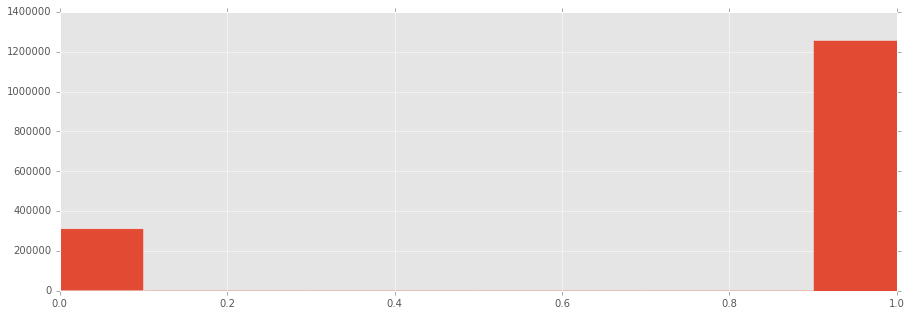

In [116]:
plt.hist(Z,bins=10)

In [328]:
len(Y_train)

1589761

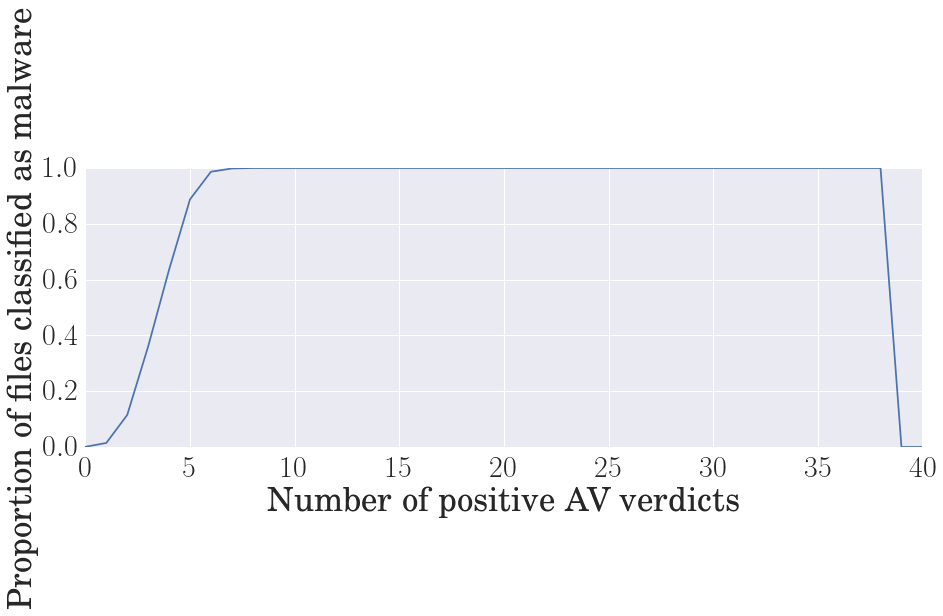

In [491]:
propn = np.zeros(41)
for i in range(0, 41):
    amt = Z_arr1[7][verdicts==i]
    if len(amt) > 0:
        propn[i] = sum(amt) / len(amt)
    else: propn[i] = 0

fig, ax = plt.subplots(1,1)
ax.plot(propn)
ax.set_xlabel("Number of positive AV verdicts")
ax.set_ylabel("Proportion of files classified as malware")

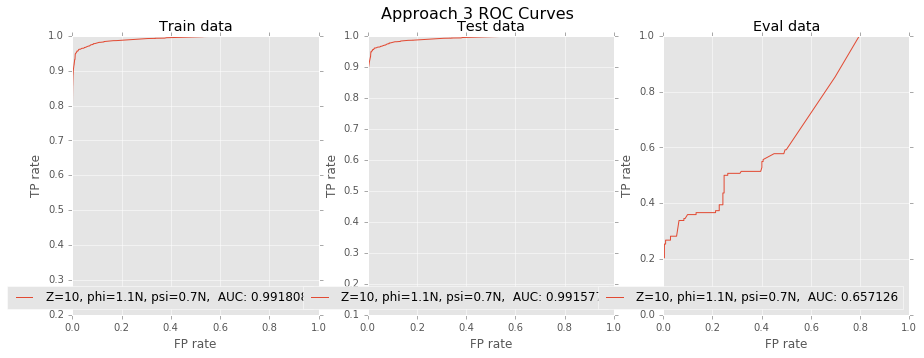

In [118]:
plot_results([clf], ["Z=10, phi=1.1N, psi=0.7N, "], "Approach 3 ROC Curves")

With similar hyperparameters to Approach 2 for the EM Algorithm, the fully generative model does not yield a significant improvement in results. Further exploration of the hyperparameter space, in particluar the initialisation of the the threshold for classification which will have high sensitivity on the settings of the integrated classifier, should hopefully yield improved results.

In [120]:
Z_fixed = np.array(Z >= gamma).astype(int)
Z_rev = np.array(Z < gamma).astype(int)
alpha_class = sum(Z * Z_fixed)/sum(Z)
beta_class = 1 - sum((1-Z)*Z_rev)/sum((1-Z))
print(alpha_class, beta_class)

0.997367989661 0.008454526147


In [119]:
np.array([5,3,4]) * np.array([1,2,4])

array([ 5,  6, 16])

To Do:

- More complete evaluation of the hyperparameter space for Approaches 2 and 3
- Performance of different approaches on additional file type corpuses:
    - PDF files
    - MS Document files
- Evaluation with additional AV information for eval set

In [358]:
import seaborn as sns

In [365]:
#corr_data = pd.DataFrame(Y)
#corr_data.rename(columns=dict(zip(np.arange(40),RL_final.columns[4:].values)), inplace=True)
corr_data = corr_data.iloc[:,arr]

In [374]:
corr = corr_data.corr()
corr.shape

(40, 40)

In [385]:
names = corr.columns.values
for i in range(0, len(names)):
    names[i] = names[i].replace('_','\_')

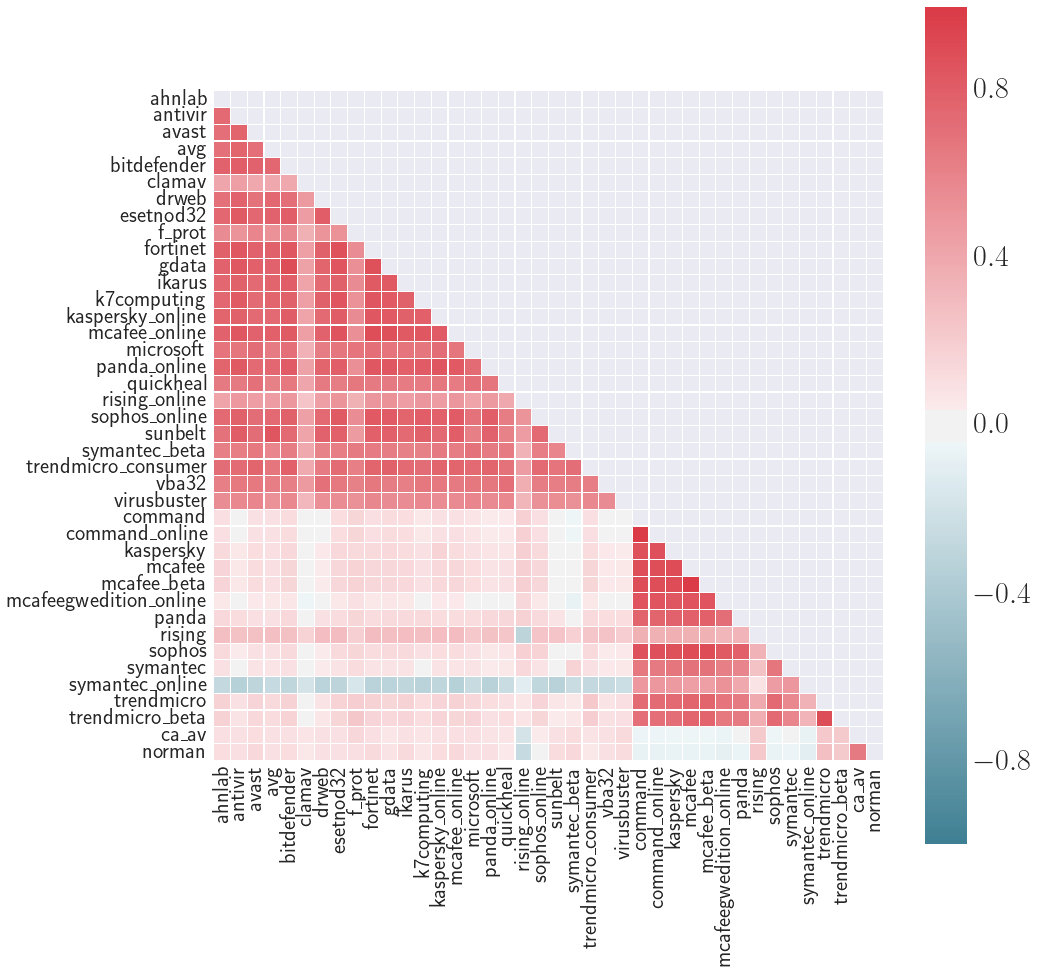

In [394]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(1, 1)

f.set_size_inches(15, 15)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.set(font_scale=3)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.values, mask=mask, cmap=cmap, vmax=1.0,
            square=True, xticklabels=names, yticklabels=names, 
            linewidths=.2, cbar_kws={"shrink": 1.0}, ax=ax)

ax.set_xticklabels(names, fontsize=22)
ax.set_yticklabels(names[::-1], fontsize=22)

f.savefig('../data/report/chp2_corr.pdf', bbox_inches='tight')

In [361]:
from sklearn.decomposition import PCA

In [362]:
pca_obj = PCA()
pca_obj.fit(corr_data)

PCA(copy=True, n_components=None, whiten=False)

In [363]:
comps = pca_obj.components_
strength = pca_obj.explained_variance_ratio_
print(strength)

[  5.68949237e-01   9.75417366e-02   4.58321400e-02   4.09120908e-02
   2.83900734e-02   2.05044217e-02   1.72895495e-02   1.40445217e-02
   1.37444686e-02   1.17904456e-02   1.09897665e-02   1.03966335e-02
   1.00480629e-02   8.90413377e-03   8.41032930e-03   8.05481777e-03
   7.45435501e-03   6.81661770e-03   6.73141544e-03   6.34207747e-03
   5.99784258e-03   5.81777030e-03   5.67976061e-03   4.88333135e-03
   4.57606702e-03   3.93772962e-03   3.58352566e-03   3.43607439e-03
   3.03574751e-03   2.59879918e-03   2.40507072e-03   2.16161188e-03
   2.09984947e-03   1.88307090e-03   1.46289185e-03   1.16730544e-03
   1.08393604e-03   9.65342172e-04   5.96404705e-05   1.77383089e-05]


In [144]:
np.argsort(abs(comps[0]))

array([21,  5, 32, 23,  7,  8, 29, 24, 16, 18, 19, 36, 35, 34, 27,  6, 28,
       39, 11, 31,  3, 33, 38,  9, 14, 26, 10,  1, 20,  2, 15,  0, 30, 13,
       22, 37, 12, 17,  4, 25], dtype=int64)

In [148]:
(comps[0] < -0.1).astype(int)

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1])

In [149]:
(comps[1] > 0.1).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0])

In [364]:
arr = np.argwhere(comps[0] < -0.1)[:,0]
arr = np.append(arr, np.argwhere(comps[1] > 0.1)[:,0])
arr = np.append(arr, np.array([5, 23]))

arr

array([ 0,  1,  2,  3,  4,  6,  9, 10, 11, 12, 13, 14, 15, 17, 20, 22, 25,
       26, 28, 30, 31, 33, 37, 38, 39,  7,  8, 16, 18, 19, 21, 24, 27, 29,
       32, 34, 35, 36,  5, 23], dtype=int64)

In [165]:
X.t

array([ 0.01405811, -0.04525712,  0.02676466, -0.04398218, -0.04556885,
        0.13099783,  0.10375259, -0.05147682, -0.05293682,  0.00102373,
       -0.06447323,  0.18157664, -0.04925533, -0.07971653, -0.01951323,
       -0.06237611, -0.05000922, -0.0148492 , -0.04321325, -0.0433402 ,
       -0.05387225, -0.05345975,  0.08752145,  0.20496319, -0.02424742,
       -0.03298044,  0.13751753,  0.52362195, -0.68181128, -0.04435612,
       -0.08233892, -0.04834194, -0.01210335,  0.1559828 , -0.02497589,
        0.05171415,  0.04618274,  0.01277447,  0.15712682,  0.14864246])

In [399]:
zero_feats = np.diff(X.indptr) == 0

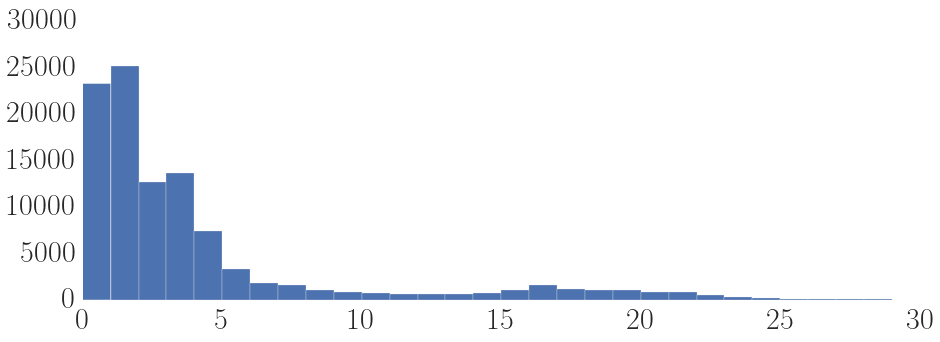

In [424]:
fig, ax = plt.subplots(1,1)
ax.set_axis_bgcolor('white')
ax.spines['top'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')

ax.hist(label_count[zero_feats], bins=np.arange(0,30))


#ax.spines['bottom'].set_color('black')
#ax.spines['left'].set_color('black')

#ax.set_ylabel('Count of files')
#ax.set_xlabel('Number of positive verdicts')
#plt.yscale('log')
fig.savefig('../data/report/temp.pdf')

In [425]:
joblib.dump(label_count[zero_feats], '../data/report/zero_feat.pkl')

['../data/report/zero_feat.pkl', '../data/report/zero_feat.pkl_01.npy']

In [428]:
joblib.dump([before, after, movement], '../data/report/data/eval_verdicts.pkl')

['../data/report/data/eval_verdicts.pkl',
 '../data/report/data/eval_verdicts.pkl_01.npy',
 '../data/report/data/eval_verdicts.pkl_02.npy',
 '../data/report/data/eval_verdicts.pkl_03.npy']

In [433]:
rng = X.shape[1]
feat_counts = np.zeros(rng)
for i in range(0, rng):
    feat_counts[i] = X[:,i].getnnz()

(1, 1200000)

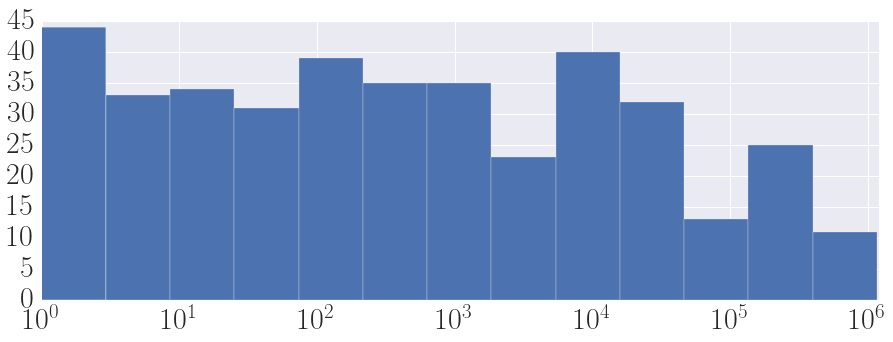

In [453]:
fig, ax = plt.subplots(1,1)

ax.hist(feat_counts, bins=np.logspace(0,7,16))
ax.set_xscale("log")
ax.set_xlim([1,1200000])

In [450]:
np.logspace(0,7,8)

array([  1.00000000e+00,   1.00000000e+01,   1.00000000e+02,
         1.00000000e+03,   1.00000000e+04,   1.00000000e+05,
         1.00000000e+06,   1.00000000e+07])

In [454]:
joblib.dump(feat_counts, '../data/report/data/feat_counts.pkl')

['../data/report/data/feat_counts.pkl',
 '../data/report/data/feat_counts.pkl_01.npy']

In [460]:
verdicts = Y_train.sum(axis=1)
joblib.dump(verdicts, '../data/report/data/verdicts.pkl')

['../data/report/data/verdicts.pkl', '../data/report/data/verdicts.pkl_01.npy']